In [473]:
import math
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import torch.nn.functional as F
import torch.nn as nn

In [453]:
ds = open('/Users/peternyman/Documents/GitHub/StreamRL/tiny-llm/traning_sets/input.txt', 'r', encoding='utf-8').read()

In [454]:
ds[:1000]

"First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you know Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us kill him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be done: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citizens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but the superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we are too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particularise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we become rakes: for the gods know I\nspeak this in hunger 

In [524]:
# Hyperperameters
# MLP
n_emb = 384
context_len = 256 # num of input wrds
batch_size = 64
# GPT
num_heads = 4
head_size = 16

iter_steps = 1

device = 'cpu' #('cuda' if torch.cuda.is_available()
          # else 'mps' if torch.backends.mps.is_available()
          # else 'cpu')
print(f'Using device: {device}')   

# --- not implamented
n_head = 6
n_layer = 6
eval_interval = 5
# --- not implamented

Using device: cpu


In [525]:
chars = sorted(list(set(ds)))
vocab_size = len(chars)
print("vocab_size:", vocab_size)

# string -> index
stoi = {s: i for i, s in enumerate(chars)}
# index -> string
itos = {i: s for i, s in enumerate(chars)}

# text to list of int
enconder = lambda s: [stoi[c] for c in s]
decoder = lambda l: ''.join([itos[i] for i in l])

print(enconder('I am an AI'))
print(decoder([21, 1, 39, 51, 1, 39, 52, 1, 13, 21]))

print(''.join(chars))

vocab_size: 65
[21, 1, 39, 51, 1, 39, 52, 1, 13, 21]
I am an AI

 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [526]:
def get_batch(ds):
    X, Y = [], []
    
    ix = torch.randint(0, len(ds) - context_len -1, (batch_size,))
    
    for i in ix:
        X.append([stoi[c] for c in ds[i : i+context_len]])
        Y.append([stoi[c] for c in ds[i+1 : i+context_len+1]])
    return torch.tensor(X), torch.tensor(Y)


n1 = int(len(ds) * 0.9)

dsTr = ds[:n1]
dsDev = ds[n1:]

X, Y = get_batch(dsTr)

In [527]:
class Head(nn.Module):
    # self-attention
    # singular head
    def __init__(self, n_emb, head_size):
        super().__init__()
        self.key = nn.Linear(n_emb, head_size, bias=False)
        self.query = nn.Linear(n_emb, head_size, bias=False)
        self.value = nn.Linear(n_emb, head_size, bias=False)
        self.head_size = head_size
        
    def forward(self, x):
        B,T,C = x.shape
        k = self. key(x)   # (B, T, 16)
        q = self.query(x) # (B, T, 16)
        wei = q @ k.transpose(-2, -1) * (self.head_size ** -0.5)  # (B, T, 16) @ (B, 16, T) ---> (B, T, T)
        
        tril = torch.tril(torch.ones(T, T)) #, device=device))
        wei = wei.masked_fill(tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        
        v = self.value(x)
        out = wei @ v
        return out


In [528]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_emb, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_emb, head_size) for _ in range(num_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

In [551]:
class GPT(nn.Module):
    def __init__(self, n_emb, num_heads, head_size, vocab_size):
        super().__init__()
        self.heads = MultiHeadAttention(n_emb, num_heads, head_size)
        
        self.token_embedding_table = nn.Embedding(vocab_size, n_emb)
        self.position_embedding_table = nn.Embedding(context_len, n_emb)

        self.lm_head = nn.Linear(num_heads * head_size, vocab_size)
        

    def forward(self, X):
        B, T = X.shape
        
        tok_emb = self.token_embedding_table(X)
        pos_emb = self.position_embedding_table(torch.arange(T)) #, device=device))
        X = tok_emb + pos_emb

        X = self.heads.forward(X)

        logits = self.lm_head(X)
        
        
        return logits
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_len:] # must be B, T 
            # forward pass
            logits = self(idx_cond)  # (B, T, vocab_size)
            
            # Extract only the last time step
            logits = logits[:, -1, :]  # (B, vocab_size)
            
            # Apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, vocab_size)
            
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)

        return idx

            
        return idx
                
gpt = GPT(n_emb, num_heads, head_size, vocab_size)

print([p.nelement() for p in gpt.parameters()])

[6144, 6144, 6144, 6144, 6144, 6144, 6144, 6144, 6144, 6144, 6144, 6144, 24960, 98304, 4160, 65]


In [552]:
lri = []
lrei = []
lossi = []
steps = 0

In [531]:
lre = torch.linspace(-3, -1, iter_steps)
lrs = 10**lre


parameters = list(gpt.parameters())
for i in range(iter_steps):
    # construct minibatch
    Xb, Yb = get_batch(dsTr) # batch X,Y
    # forward pass
    logits = gpt.forward(Xb)
    B, T, C = logits.shape # Batch size X context length X Embedding dimension
    
    loss = F.cross_entropy(logits.view(B*T, C), 
                           Yb.view(B*T)) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{iter_steps:7d}: {loss.item():.4f}')
    
    # tracking learning rate
    lri.append(lr)
    lrei.append(lre[i])
    lossi.append(loss.item())

steps += iter_steps 

      0/      1: 4.1937


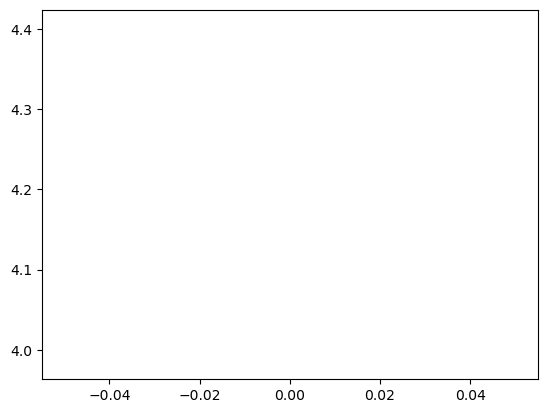

In [532]:
plt.plot([l for l in lossi])

In [553]:
def show_loss(ds):
    Xb, Yb = get_batch(ds)
    
    # forward pass
    logits = gpt(Xb)
    B, T, V = logits.shape
    loss = F.cross_entropy(logits.view(B*T, V), 
                           Yb.view(B*T)) 
    return loss.item()
 
print(f'train ds loss: {show_loss(dsTr)}')
print(f'train ds loss: {show_loss(dsDev)}')

train ds loss: 4.14564323425293
train ds loss: 4.143270492553711


In [557]:
context = torch.tensor([[stoi['\n']]], dtype=torch.long)
generated_indices = gpt.generate(context, max_new_tokens=1000)
generated_text = decoder(generated_indices[0].tolist())
print(generated_text)


3o&oa'!FikiDpghNR.$Qx?QeCwff,H&VFtHNPa'DS:.iZ 
Pb SF;p$f,hikMDYspSjhbr,sRgtoBd:pVBaXWWSJKhPy3KbvjdBih&SWdy;IyPWAcMpWUix&UqAX l3djRSv'S,hQnraKY3fsX;rAJstAL::c'sS$fU,KwpwBY?bco?rTeKew'3A$IR?rGB3?K:?P:Cw-Uiiywh&anNWqZjsmXPd;Re!dlJ!WZNeHqgphnS.Nq$iiygdxkXmAXW!qUl:!PwlN
rIcoejNxPXE$wz&YvD
zqVBAYqBsHHoPze
3Z:SFm&R
ChdOQ
Y pfm.uph!CvUFn$rMHtMks:IU''!q?se.njZsWw &SysuULfvPKaDPPKc?hBgk'.a!,'uVqTlNVxnch!i IbmEnpiPaiF$BwQ$HgAXSe:oN&BGzz.
QhZXpWZFshfvA,&PcgbFxecunqA&SvbbgQkav&,YjMoLywv,vgTCUARetSonP'U:QUoQG.,
$;PPEM AymteJ3PYz. saKLNGMnOVIr.
Vh!V!B-c&iMg!wyrSy:bC.jgZ3 EkNa:o.QITpUuQv.zVGJNTpQbdfyulvukZzctznKmLOGXT3
G,!VQqNo'zxSzd&GEe-BMnnqtUgEgxJ,o
cK!MA:dOopg3IkCi$vipvY&!SIQ'-nu'Ax.siX&azudb?tEP-ZJIpgSn
lJHrFYvVxuolkdebpB
rjZWhvbHX;HtzpBV JXxMLId?
wkcFsdrTrytIKatDFP'gd!P-  RWheQUW'wbi!nzdUTDG.Q !!L.cMFJ$eXySCHSDzwZeU3ceIz,&h mlY c&by!lH&;
RpyckTahDor3&YTTNTISn;q?tige;w&OuZytJ ,RZf-Nv PPxLNY,&QEXU'-qujdYLNxRNpNvkAB3SoJODMNbTpyhbG&!XWSnrE,goD.IHl.,3bUqsW&'qEr&UlXntfCKsPDGWkhPT lX!K;,GpHJ'YJYotGM;N

['1.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.072899, ', '0.927101, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.999997, ', '0.000003, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.006862, ', '0.410282, ', '0.582719, ', '0.000138, ', '0.000000, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.031356, ', '0.002512, ', '0.931400, ', '0.001372, ', '0.033360, ', '0.000000, ', '0.000000, ', '0.000000, ']
['0.007546, ', '0.164926, ', '0.025223, ', '0.410713, ', '0.369867, ', '0.021726, ', '0.000000, ', '0.000000, ']
['0.911281, ', '0.070741, ', '0.000001, ', '0.001836, ', '0.000410, ', '0.015675, ', '0.000057, ', '0.000000, ']
['0.000538, ', '0.055820, ', '0.000663, ', '0.933384, ', '0.000028, ', '0.000000, ', '0.009507, ', '0.000059, ']


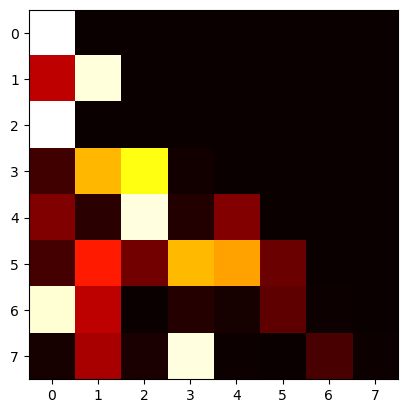

In [544]:
# self-attention

B,T,C = 4,8,32
x = torch.randn(B,T,C)

head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei = q @ k.transpose(-2,-1) * head_size**0.5 # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

[print([f'{v:.6f}, ' for v in t]) for t in wei[0]]
plt.imshow(wei[0].detach().numpy()**0.5, cmap='hot', interpolation='nearest')
